[View in Colaboratory](https://colab.research.google.com/github/mogamin/chainer-examples/blob/master/chainer_PotatoChips_Classification.ipynb)

In [1]:
# 
![ ! -e ./data ] && curl -L "https://rebrand.ly/dllab2018-hackathon-cv" -o data.tar.gz && gzip -d -c data.tar.gz | tar xf -

!apt-get install -y -qq libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80==4.3.0 
!pip install chainer==4.3.0
!pip install chainercv

import chainer
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


In [0]:
import chainer
import chainer.links as L
import chainer.functions as F
from chainer.datasets import LabeledImageDataset
from chainer.datasets import TransformDataset

In [0]:
from chainercv.transforms import resize

# 画像データの前処理変換
class ImageTransform(object):
    def __call__(self, in_data):
        img, label = in_data
        #_, H, W = img.shape
        #img = random_sized_crop(img)
        img = resize(img, (224, 224))
        #img = random_flip(img, x_random=True)
        return img, label

In [0]:
# データのロード
train = LabeledImageDataset('data/train/train_labels.txt', root='data/train/images')
train = TransformDataset(train, ImageTransform())
valid = LabeledImageDataset('data/valid/valid_labels.txt', root='data/valid/images')
valid = TransformDataset(valid, ImageTransform())

In [0]:
class PotatoMLP(chainer.Chain):
  def __init__(self, n_mid_units=5, n_class=9):
    super().__init__()
    with self.init_scope():
        self.fc1 = L.Linear(None, n_mid_units)
        self.fc2 = L.Linear(None, n_mid_units)
        self.fc3 = L.Linear(None, n_class)
  
  def __call__(self, x):
    h = self.fc1(x)
    h = F.relu(h)
    h = self.fc2(h)
    h = F.relu(h)
    h = self.fc3(h)
    return h     

In [0]:
BATCHSIZE = 100
EPOCH=10
GPUID=0

In [0]:
train_iter = chainer.iterators.SerialIterator(train, BATCHSIZE)
valid_iter = chainer.iterators.SerialIterator(valid, BATCHSIZE, repeat=False, shuffle=False)

In [16]:
#
mlp = PotatoMLP(224, 9)
model = L.Classifier(mlp)
if GPUID >= 0:
  model.to_gpu(GPUID)
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [17]:
#
from chainer.training import extensions

updater = chainer.training.StandardUpdater(train_iter, optimizer, device=GPUID)
trainer = chainer.training.Trainer(updater, (EPOCH, 'epoch'), out='result/potato')
trainer.extend(extensions.Evaluator(valid_iter, model, device=GPUID))
trainer.extend(extensions.LogReport(trigger=(1,'epoch')))
trainer.extend(extensions.PrintReport(['epoch','main/accuracy','validation/main/accuracy','main/loss','validation/main/loss','elapsed_time']), trigger=(1,'epoch'))
trainer.extend(extensions.ProgressBar(update_interval=100))
trainer.run()

     total [####..............................................]  9.49%
this epoch [###############################################...] 94.91%
       100 iter, 0 epoch / 10 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.173491       0.352                     3917.56     265.838               212.734       
     total [#########.........................................] 18.98%
this epoch [############################################......] 89.83%
       200 iter, 1 epoch / 10 epochs
   0.49633 iters/sec. Estimated time to finish: 0:28:39.808690.
2           0.331143       0.3265                    356.805     243.832               423.102       
     total [##############....................................] 28.47%
this epoch [##########################################........] 84.74%
       300 iter, 2 epoch / 10 epochs
   0.49819 iters/sec. Estimated time t

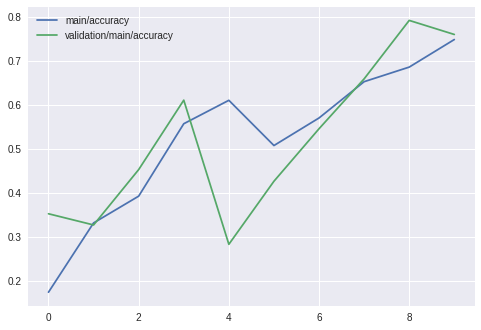

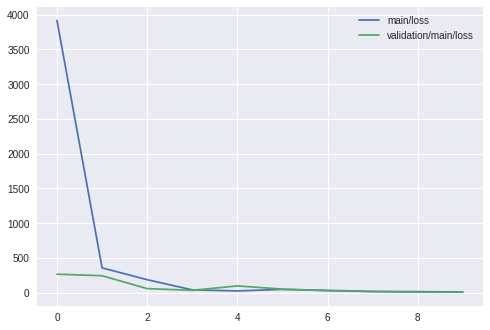

In [22]:
import json
import pandas as pd
with open('result/potato/log') as f:
  result = pd.DataFrame(json.load(f))

result[['main/accuracy','validation/main/accuracy']].plot()
result[['main/loss','validation/main/loss']].plot()

In [26]:
  import os
  
  # Evaluate on test dataset
  test = LabeledImageDataset('data/test/test_labels.txt', root='data/test/images')
  test = TransformDataset(test, ImageTransform())
  test_iter = chainer.iterators.SerialIterator(test, 1000, repeat=False, shuffle=False)
  test_evaluator = extensions.Evaluator(test_iter, model, device=GPUID)
  results = test_evaluator()

  msg = 'Test loss\t:{}\n'.format(results['main/loss'])
  msg += 'Test accuracy\t:{}'.format(results['main/accuracy'])
  print(msg)
  print(msg, file=open(os.path.join('./', 'test_result.txt'), 'w'))

  chainer.serializers.save_npz(os.path.join('./', 'model_iter_{}'.format(updater.iteration)), model)

Test loss	:7.3767443
Test accuracy	:0.74256545
